In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers

# Load EEG data from CSV
eeg_data = pd.read_csv(r"C:\Users\HP\Desktop\Dataset\Model_Input_2sec\LR_2sec.csv")

# Define the number of rows in each epoch (4 seconds)
epoch_length = 321

# Initialize lists to store epochs and labels
epochs = []
labels = []

# Extract EEG data and labels
for i in range(0, len(eeg_data), epoch_length):
    epoch = eeg_data.iloc[i:i + epoch_length]
    if len(epoch) == epoch_length:
        eeg_epoch = epoch.iloc[:, 1:-1].values  # Assuming EEG channels are from column 1 to the second-to-last column
        label = epoch.iloc[0, -1]  # Assuming the target is in the last column
        epochs.append(eeg_epoch)
        labels.append(label)

# Convert to NumPy arrays
epochs = np.array(epochs)
labels = np.array(labels)

# Perform label encoding for multi-class classification
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(epochs, labels_encoded, test_size=0.2, random_state=42)

# Define EEGNet architecture
model = keras.Sequential()
model.add(layers.Conv2D(8, (1, 64), input_shape=(epochs.shape[1], epochs.shape[2], 1), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.DepthwiseConv2D(kernel_size=(epochs.shape[1], 1), depth_multiplier=2, depthwise_initializer='he_normal', use_bias=False, padding='valid'))
model.add(layers.BatchNormalization())
model.add(layers.DepthwiseConv2D(kernel_size=(1, 16), depth_multiplier=2, depthwise_initializer='he_normal', use_bias=False, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('elu'))
model.add(layers.AveragePooling2D(pool_size=(1, 4)))
model.add(layers.Dropout(0.5))
model.add(layers.SeparableConv2D(16, (1, 16), activation='elu', depthwise_initializer='he_normal', use_bias=False, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.SeparableConv2D(16, (1, 16), activation='elu', depthwise_initializer='he_normal', use_bias=False, padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.AveragePooling2D(pool_size=(1, 4)))  # Adjust the pool_size as needed
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))  # 3 classes (Left, Right, Rest)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Reshape data to match the input shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Train the model
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Epoch 1/15
2/2 [==============================] - 4s 747ms/step - loss: 1.7335 - accuracy: 0.2391 - val_loss: 1.1015 - val_accuracy: 0.5000
Epoch 2/15
2/2 [==============================] - 1s 318ms/step - loss: 1.1311 - accuracy: 0.3913 - val_loss: 1.0799 - val_accuracy: 0.6667
Epoch 3/15
2/2 [==============================] - 1s 322ms/step - loss: 1.1007 - accuracy: 0.4783 - val_loss: 1.0657 - val_accuracy: 0.6667
Epoch 4/15
2/2 [==============================] - 1s 319ms/step - loss: 1.3191 - accuracy: 0.4348 - val_loss: 1.0543 - val_accuracy: 1.0000
Epoch 5/15
2/2 [==============================] - 1s 307ms/step - loss: 0.8826 - accuracy: 0.5652 - val_loss: 1.0452 - val_accuracy: 1.0000
Epoch 6/15
2/2 [==============================] - 1s 323ms/step - loss: 0.9276 - accuracy: 0.5217 - val_loss: 1.0391 - val_accuracy: 1.0000
Epoch 7/15
2/2 [==============================] - 1s 312ms/step - loss: 0.9351 - accuracy: 0.4783 - val_loss: 1.0348 - val_accuracy: 1.0000
Epoch 8/15
2/2 [====

Epoch 1/4
2/2 [==============================] - 1s 374ms/step - loss: 0.6512 - accuracy: 0.7391 - val_loss: 0.9826 - val_accuracy: 0.8333
Epoch 2/4
2/2 [==============================] - 1s 382ms/step - loss: 0.5514 - accuracy: 0.7609 - val_loss: 0.9740 - val_accuracy: 0.8333
Epoch 3/4
2/2 [==============================] - 1s 380ms/step - loss: 0.4567 - accuracy: 0.8043 - val_loss: 0.9660 - val_accuracy: 0.8333
Epoch 4/4
2/2 [==============================] - 1s 336ms/step - loss: 0.4488 - accuracy: 0.8043 - val_loss: 0.9585 - val_accuracy: 0.8333


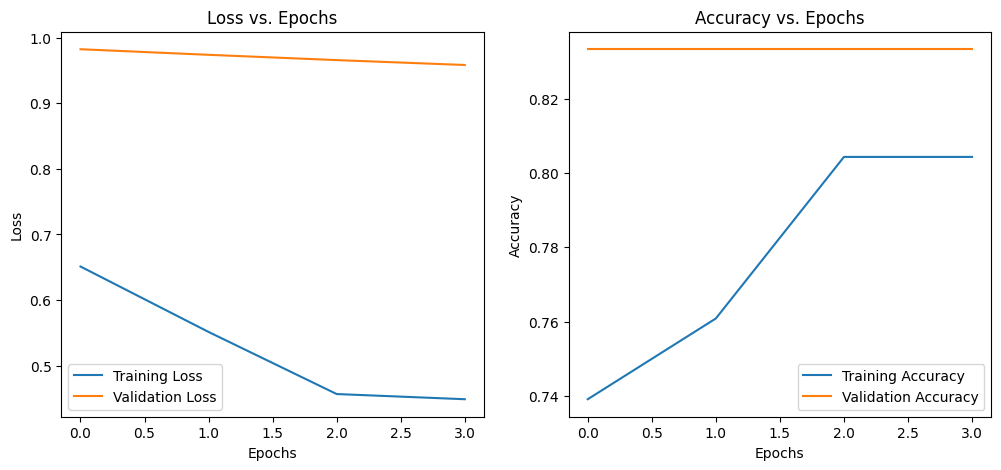

1/1 [==============================] - 0s 123ms/step - loss: 1.0004 - accuracy: 0.4348
Test Loss: 1.0004256963729858, Test Accuracy: 0.43478259444236755
1/1 [==============================] - 0s 277ms/step
              precision    recall  f1-score   support

           0       0.44      0.73      0.55        11
           1       0.40      0.17      0.24        12

    accuracy                           0.43        23
   macro avg       0.42      0.45      0.39        23
weighted avg       0.42      0.43      0.39        23



In [13]:
import matplotlib.pyplot as plt

# Train the model and collect the training history
history = model.fit(X_train, y_train, epochs=4, batch_size=32, validation_split=0.1)

# Plot loss vs. accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')
plt.show()

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# You can also print other classification metrics using scikit-learn, such as precision, recall, and F1 score.
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels
print(classification_report(y_test, y_pred))


In [14]:
import pandas as pd
import numpy as np

# Load external EEG data from a CSV file
external_data = pd.read_csv(r"C:\Users\HP\Desktop\Dataset\Model_Input\sub_6_run3_Input_2secs.csv")

# Assuming your external data contains the same structure as your training data
# Adjust the column selections accordingly
external_data = external_data.iloc[:, 1:-1].values  # Assuming EEG channels are from column 1 to the second-to-last column

# Ensure the data shape matches the model's input shape
external_data = external_data.reshape(1, external_data.shape[0], external_data.shape[1], 1)

# Make predictions using the trained model
predictions = model.predict(external_data)

# Decode the predictions (if you used label encoding)
decoded_predictions = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

# Display the predictions
print("Predicted class:", decoded_predictions[0])


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_4/dense_4/BiasAdd' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelapp.py", line 728, in start
      self.io_loop.start()
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once
      handle._run()
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\HP\AppData\Local\Temp\ipykernel_19308\884166121.py", line 15, in <module>
      predictions = model.predict(external_data)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
      return self(x, training=False)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py", line 252, in call
      outputs = tf.nn.bias_add(outputs, self.bias)
Node: 'sequential_4/dense_4/BiasAdd'
Matrix size-incompatible: In[0]: [1,595840], In[1]: [48,3]
	 [[{{node sequential_4/dense_4/BiasAdd}}]] [Op:__inference_predict_function_23106]

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

# Load external EEG data from a CSV file
external_data = pd.read_csv(r"C:\Users\HP\Desktop\Dataset\Model_Input\sub_6_run3_Input_2secs.csv")

# Define the number of rows in each epoch (641 rows for 4 seconds)
epoch_length = 321

# Initialize lists to store true targets and predictions
true_targets = []
all_predictions = []

# Iterate through the external data file, predicting one epoch at a time
for i in range(0, len(external_data), epoch_length):
    # Extract one epoch of data
    epoch_data = external_data.iloc[i:i + epoch_length, 1:-1].values  # Assuming EEG channels are from column 1 to the second-to-last column
    epoch_targets = external_data.iloc[i, -1]  # Assuming targets are in the last column and taken once for each epoch

    # Ensure the data shape matches the model's input shape
    epoch_data = epoch_data.reshape(1, epoch_data.shape[0], epoch_data.shape[1], 1)

    # Make predictions using the trained model
    predictions = model.predict(epoch_data)

    # Decode the predictions (if you used label encoding)
    decoded_predictions = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

    # Append the true target and predictions for this epoch
    true_targets.append(epoch_targets)
    all_predictions.extend(decoded_predictions)

# Create a DataFrame to display true targets and predictions
result_df = pd.DataFrame({'True Targets': true_targets, 'Predictions': all_predictions})

# Print the table of true targets and predictions
print(result_df)

# Calculate accuracy by comparing true targets to predictions
accuracy = accuracy_score(true_targets, all_predictions)
print("Accuracy:", accuracy)

# Determine if predictions and true targets match for each row
result_df['Match'] = result_df['True Targets'] == result_df['Predictions']

# Print if predictions and true targets match for each row
print(result_df)


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_4/dense_4/BiasAdd' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelapp.py", line 728, in start
      self.io_loop.start()
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once
      handle._run()
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\HP\AppData\Local\Temp\ipykernel_19308\884166121.py", line 15, in <module>
      predictions = model.predict(external_data)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
      return self(x, training=False)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py", line 252, in call
      outputs = tf.nn.bias_add(outputs, self.bias)
Node: 'sequential_4/dense_4/BiasAdd'
Matrix size-incompatible: In[0]: [1,64], In[1]: [48,3]
	 [[{{node sequential_4/dense_4/BiasAdd}}]] [Op:__inference_predict_function_23106]